In [41]:
#get_ipython().magic('reset -sf')

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy as sc
from scipy import ndimage
from IPython import get_ipython
%matplotlib inline

FIGURES_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/figures/working_memory_usage_model/'
SIMULATION_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/simulations/'
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    
import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functions.logProcess import logProcess
from functions.odeint import odeint

mpl.rcParams['axes.linewidth'] = 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap

FIGURES_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/figures/'
SUP_FIG_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/sup_figures/'

# Functions

In [42]:
def getStrWithNotZero(val, digits = 1):
    val = np.round(val, digits)
    val_str = str(val)
    
    for i in range(len(val_str)):
        if val_str[i] == '.':
            return val_str[i:]
        
    return val_str 

    
def defineInitialWeights(N, amp, sigma):
    
    if sigma == 0:
        wEE = amp*np.identity(N)
        return w1
    
    i = np.arange(0,N,1)
    j = np.arange(0,N,1)
    
    i,j = np.meshgrid(i,j)
    
    diff = np.abs(i - j)
    diff = np.stack([diff, N-diff])
    diff = np.min(diff, axis=0)
    
    wEE = amp * np.exp( -np.power( diff ,2 )/ (2*np.power( sigma, 2 )) )

    return wEE



def getInputProfile(N, i, amp, sigma):
    I = np.zeros(N)

    if sigma == 0:
        ix = i - (i//N)*N

        I[ix] = 1
        return I
    
    
    j = np.arange(0,N,1)
    diff = np.abs(j - i)
    diff = np.stack([diff, N-diff])
    diff = np.min(diff, axis=0)
    I = amp * np.exp( - np.power(diff, 2)/(2*(sigma**2)) )
    return I



def plotwEE(wEE):
    fig, axes = plt.subplots(1,2, figsize= (20,10))
    axes[0].set_title(r'$w_{EE}^{(ij)}$')
    wEE_im = axes[0].imshow(wEE, cmap = 'hot')
    
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="10%", pad=0.1)
    barwEE = plt.colorbar(wEE_im, cax=cax, ticks=[np.min(wEE), np.max(wEE)])
    
    axes[1].plot(wEE)
        
def flashingInput(N, num_input, time, time_step, on_phase = 0.5, off_phase = 0.5, sigma = 2):
    I = np.zeros([len(time), N])

    cell = np.zeros(num_input)
    
    
    for i in range(num_input):
        cell[i] = i - (i//N)*N
        
    
    
    for i in range(num_input-1):
        curr_cell = int(cell[i] + int(N/2))
        
        durationInput = int(on_phase/time_step)
        durationRest  = int(off_phase/time_step)
        min_ix = (durationRest + durationInput)*i
        max_ix = durationRest*i + durationInput*(i+1)
        
        I[min_ix:max_ix,:] = getInputProfile(N, curr_cell, 1, sigma)
        
    return I
    


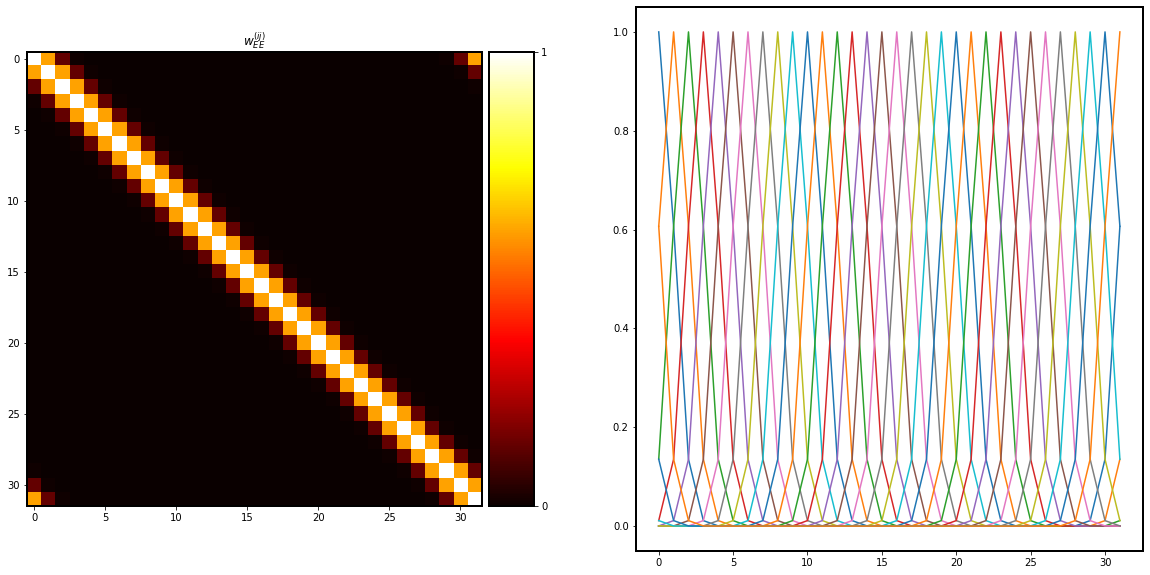

In [3]:
N = 32
wEE = defineInitialWeights(N, 1, 1)
plotwEE(wEE)


In [4]:
def plotSolutionAnalysis(X, params, min_time, max_time, time_step, sigma, points = 10000, roll_bump = 0):
    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.0, 0.0)],

             'green': [(0.0,  0.1, 0.1),
                       (1, 1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)]}
    gfp = LinearSegmentedColormap('gfp', cdict, N=256, gamma=0.5)

    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)],

             'green':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)]}
    vis = LinearSegmentedColormap('vis', cdict, N=256, gamma=0.5)

    
    
    
    


    time, rE, rI, wEE, wIE, rI_filt = X
    tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N, I, sleep, m, time_step   = params

    
    if max_time == -1:
        max_time = time[-1]
    
    min_ix = np.where(time > min_time)[0][0]
    max_ix = np.where(time < max_time)[0][-1]
    ix = np.linspace(min_ix, max_ix, points).astype(np.int)
    
    sleep   = sleep[ix]
    time    = time[ix]
    rE      = np.roll(rE[ix,:], roll_bump, axis = 1)
    rI      = rI[ix]
    rI_filt = rI_filt[ix]
    I       = np.roll(I[ix,:], roll_bump, axis = 1)

    wEE = wEE[ix]
    wEE = np.roll(wEE, roll_bump, axis = 1)
    wEE = np.roll(wEE, roll_bump, axis = 2)

    wIE = np.roll(wIE[ix,:], roll_bump, axis = 1)
    



    linewidth = 10
    
    
        
    fsize = 75
    plt.rcParams.update({'font.size': fsize})
    plt.rcParams['axes.linewidth'] = 7

    fig, axes = plt.subplots(7, 1, sharex=True, figsize=(85, 45))
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(top=0.6)


    
    
    ################## sleep and wake areas in the top ###############
    
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[0].fill_between(time, 0, 1,
                 where=sleep == 1 ,
                 facecolor='black', alpha=0.2)
    
    axes[0].set_ylim([0,1])
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    axes[0].axis('off')

    
    
    
    
    
    ############# INPUT ###############
    imI = axes[1].imshow(I.transpose(), aspect='auto', cmap = vis, origin='lower', 
                         extent = (min_time, max_time, 0, N-1 ) )
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barI = plt.colorbar(imI, cax=cax, ticks=[0, Imax])
    barI.ax.set_yticklabels(['0', '$I_{max}$'])

    axes[1].set_yticks([])
    axes[1].set_ylabel('Input')


    axes[1].spines["bottom"].set_color("white")

    
    ################ BUMP ################
    axes[2].spines["top"].set_color("white")
    imrE = axes[2].imshow(rE.transpose(), aspect='auto', cmap = gfp, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    
    axes[2].set_ylabel('Bump')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barrE = plt.colorbar(imrE, cax=cax, ticks=[0, r0])
    barrE.ax.set_yticklabels(['0', '$r_0$'])
    axes[2].set_yticks([])


    ############ WEDGE NEURON 16 #############
    axes[3].plot(time, rE[:,16], color='green', linewidth = linewidth)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[3].set_ylabel('$r_E^{(16)}(t)$')

    #axes[2].set_ylim([np.min(h[ix]) - 0.5*h_0, 2*h_0])

    plt.sca(axes[3])
    axes[3].yaxis.tick_right()
    plt.yticks([0, r0], ['0', '$r_0$'])
    axes[3].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')
    axes[3].axhline(r0, color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[3].set_xlim(min_time, max_time)

    
    
    ################# RING NEURONS ###############
    
    axes[4].plot(time, rI, color='lightcoral', linewidth = linewidth)
    axes[4].plot(time, rI_filt, color='darkred', linewidth = linewidth)
    divider = make_axes_locatable(axes[4])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[4].set_ylabel('$r_I(t)$')
    plt.sca(axes[4])
    axes[4].yaxis.tick_right()
    plt.yticks([rI_min[0], rI_max[0]], [r'$r_I^{(min)}$', r'$r_I^{(max)}$'])
    axes[4].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')

    axes[4].axhline(rI_min[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[4].axhline(rI_max[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")

    
    axes[4].set_xlim(min_time, max_time)
    axes[4].set_ylim([np.min(rI_filt) - 5, np.max(rI_filt) + 5])

    
    
    
    
    ############# w_EE #################
    
    wEE_diag = np.zeros([wEE.shape[0], wEE.shape[1]])
    diag_ix = np.arange(0,N,1)
    wEE_diag[:, diag_ix] = wEE[:,diag_ix, diag_ix]
    
    wEE_sum = np.sum(wEE[:,16,:], axis = 1)    
    im_wEE = axes[5].imshow(wEE_diag.transpose(), aspect='auto', cmap = 'hot', origin='lower', 
                         extent = (min_time, max_time,  np.min(wEE_sum) - 0.05,  np.max(wEE_sum) + 0.05) )

    axes[5].plot(time, wEE_sum, color='white', linewidth = linewidth)
    
    plt.sca(axes[5])
    axes[5].yaxis.tick_right()
    plt.yticks([1,2])
    axes[5].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'white')


    
    divider = make_axes_locatable(axes[5])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    

    barwEE = plt.colorbar(im_wEE, cax=cax, ticks=np.round( [ np.min(wEE_diag)+0.05, np.max(wEE_diag)-0.05], 1))
    
    
    axes[5].set_ylabel(r'$w_{EE}^{(i,i)}$')
    

    
    
    ################### w_IE #######################
    
    wIE_mean = np.mean(wIE, axis = 1)
    im_wIE = axes[6].imshow(wIE.transpose(), aspect='auto', origin='lower', cmap = 'Greens', 
                         extent = (min_time, max_time, np.min(wIE_mean)- 0.1, np.max(wIE_mean) + 0.1) )
    
    axes[6].plot(time, wIE_mean, color='black', linewidth = linewidth)

    divider = make_axes_locatable(axes[6])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    
    barwIE = plt.colorbar(im_wIE, cax=cax, ticks=[0, np.round( np.max(wIE)-0.1, 1)])
    
    axes[6].set_xlim(min_time, max_time)
    
    sleep_state = sleep.astype(np.int32)
    sleep_switch = np.abs(sleep_state[1:] - sleep_state[:-1])
    
    ix_switch = np.where(sleep_switch == 1)
    time_ticks = np.round(time[ix_switch], 0)
    
    plt.sca(axes[6])
    axes[6].yaxis.tick_right()
    min_wIE = np.min(wIE_mean)
    max_wIE = np.max(wIE_mean)
    plt.yticks([min_wIE, max_wIE], [getStrWithNotZero(min_wIE), getStrWithNotZero(max_wIE)])
    axes[6].set_ylabel(r'$w_{IE}^{(i)}$')
    axes[6].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'grey')

    
    
    
    

    
    axes_fillin = [0,3,4,6]

        
    for i in range(7):
        if i not in axes_fillin:
            plt.sca(axes[i])
            #plt.xaxis.set_label_position('top') 

            plt.xticks(time_ticks)
            axes[i].xaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'white')

        if i in [3,4]:
            for t in time_ticks:
                axes[i].axvline(t, color='grey', linewidth = linewidth/2, linestyle = "dashed")
        
        if i == 6:
            plt.sca(axes[i])
            plt.xticks(time_ticks)
            axes[i].xaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'grey') 
        if i == 0:
            plt.sca(axes[i])
            axes[0].set_xticks(time_ticks)
            axes[i].xaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'black')             
    return axes



In [13]:


def plotSolutionZoom(X, params, center_time, range_time, time_step, sigma, name, roll_bump = 0, show_min = False):

    min_time = center_time - range_time/2
    max_time = center_time + range_time/2
    
    
    if max_time == -1:
        max_time = time[-1]

    time, rE, rI, wEE, wIE, rI_filt = X
    tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N, I, sleep, m, time_step   = params


    

    
    
    points = 1000000
    min_ix = np.where(time > min_time)[0][0]
    max_ix = np.where(time < max_time)[0][-1]
    ix = np.linspace(min_ix, max_ix, points).astype(np.int)
    
    
    
    rE  = np.roll(rE[ix,:], roll_bump, axis = 1)
    rI  = rI[ix]
    rI_filt = rI_filt[ix]
    I  = np.roll(I[ix,:], roll_bump, axis = 1)

    wEE = wEE[ix]

    wEE = np.roll(wEE, roll_bump, axis = 1)
    wEE = np.roll(wEE, roll_bump, axis = 2)

    wIE = np.roll(wIE[ix,:], roll_bump, axis = 1)
    
    
    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.0, 0.0)],

             'green': [(0.0,  0.1, 0.1),
                       (1, 1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)]}


    gfp = LinearSegmentedColormap('gfp', cdict, N=256, gamma=0.5)
    
    
    

    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)],

             'green':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)]}


    vis = LinearSegmentedColormap('vis', cdict, N=256, gamma=0.5)




    linewidth = 7
    
    
    
    
        
    fsize = 75
    plt.rcParams.update({'font.size': fsize})
    plt.rcParams['axes.linewidth'] = 7

    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(25, 25))
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(right=0.8)


    

    ################### INPUT #####################

    imI = axes[0].imshow(I.transpose(), aspect='auto', cmap = vis, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    

    axes[0].set_yticks([])
    axes[0].set_ylabel('Input')

    
    
    axes[0].spines["bottom"].set_color("white")

    
    ################ BUMP ################
    axes[1].spines["top"].set_color("white")
    
    
    imrE = axes[1].imshow(rE.transpose(), aspect='auto', cmap = gfp, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    
    axes[1].set_ylabel('Bump')
    axes[1].set_yticks([])

    ############### WEDGE NEURON 16 #################

    axes[2].plot(time[ix], rE[:,16], color='green', linewidth = linewidth)
    divider = make_axes_locatable(axes[2])


    plt.sca(axes[2])
    axes[2].yaxis.tick_right()
    plt.yticks([0, r0], ['0', '$r_0$'])
    
    axes[2].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')
    axes[2].axhline(r0, color='grey', linewidth = linewidth/2, linestyle = "dashed")

    axes[2].set_xlim(min_time, max_time)

    
    
    ################# RING NEURONS ###############
    

    axes[3].plot(time[ix], rI, color='lightcoral', linewidth = linewidth, label = r'r_I(t)')
    axes[3].plot(time[ix], rI_filt, color='darkred', linewidth = linewidth, label = r'r_I(t)')

    axes[3].set_ylabel('$r_I(t)$')
    plt.sca(axes[3])
    axes[3].yaxis.tick_right()
    
    
    
    
    if not show_min:
        plt.yticks([rI_max[0]], [r'$r_I^{(max)}$'])
        axes[3].axhline(rI_max[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")
    
    else:
        plt.yticks([rI_min[0]], [r'$r_I^{(min)}$'])
        axes[3].axhline(rI_min[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")
    
    axes[3].set_xlim(min_time, max_time)
    axes[3].set_ylim([np.min(rI) - 2, np.max(rI) + 2])

    
    
    
        
    axes_fillin = [2,3]
        
        
        
    
    for i in range(4):
        if i not in axes_fillin:
            plt.sca(axes[i])
            plt.xticks([min_time, center_time, max_time], 
                       ['-' + str(int(range_time/2)), int(center_time), '+' + str(int(range_time/2))])
            axes[i].xaxis.grid(True, linewidth = linewidth/2, linestyle='dashed', color = 'white')
        else:
            axes[i].axvline(center_time, color='grey', linewidth = linewidth/2, linestyle = "dashed")




# RESSETING THE WEIGHTS DURING SLEEP WITHOUT AUTONOMOUS ACTIVITY


Assuming anti-Hebbian plasticity in the ring attractor network during sleep leads to autonomous dynamics (section \ref{sec_ring_attractor_with_plastcity). A different way to reset} the network connectivity $w_{EE}^{(ij)}(t)$ is to relax it to its initial values over the sleep phase:


\begin{equation}\label{eq_relaxing_plasticity_rule}
    \tau_{EE} w_{EE}^{(ij)}(t) = - w_{EE}^{(ij)}(t) + w_{EE}^{(ij)}(0) \quad\quad\quad\quad \text{for} \quad\quad i,j = 1,..., N.
\end{equation}



The following simulation shows the ring attractor model using this type of plasticity during sleep. During the wake phase the dynamics of the model does not change (top, white regions). However, during sleep the plasticity rule keeps the bump in wedge neurons in place (top, grey regions), maintaining the last head direction of the fly before the sleep phase while the activity of R5 neurons slowly decreases. As with the two-population model, the timescale of sleep and wake phases depends on the time constants of the plasticity rules.

### PARAMETERS 

In [6]:
####### PARAMS ########
N = 32
Imax   = 3.5
Isigma = 2

tau      = 0.01
tauEE   = 10000
tauIE   = 10000
tau_filt = 2


r0  = 10
wEI = 0.5
theta = 10

rI_min = 22
rI_max = 35


wEE_max   = 0.3
wEE_sigma = 1.5

In [7]:
def limit_m(m):
    if m >= N:
        m -= N
    if m < 0:
        m += N-1 
    return m


def limitPlasticityRuleToPositive(dwdt, w):
    ix = np.where(w <= 0)
    dwdt[ix] = np.clip(dwdt[ix], 0, None)
    return dwdt




def getSimulation(params, initial_conditions, max_time, time_step, log = True):
    tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N = params
    
    if not isinstance(rI_min, list):
        rI_min = [rI_min]*1000
        
    if not isinstance(rI_max, list):
        rI_max = [rI_max]*1000
    
    params = [tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N]
    
    ###### Euler method parameters #########
    time = np.arange(0, max_time, time_step)
    
    
    ############e initial conditions ###########
    I = np.zeros([len(time), N])
    sleep = np.zeros(len(time), dtype = 'bool')
    sleep[0] = 0 # start with wake phase
    sleep_dep = np.zeros(len(time))
    
    
    count_wake_phase = 0
    m = np.zeros(len(time))
    m[0] = int(N/2)
    
    
    rE_0, rI_0, wIE_0, wEE_max, wEE_sigma, rI_filt_0 = initial_conditions
    
    
    rE      = rE_0*  np.ones( N )
    rI      = rI_0*  np.ones( 1 )
    wEE_0     = defineInitialWeights( N, amp = wEE_max, sigma = wEE_sigma ) 
    wIE     = wIE_0* np.ones( N )
    rI_filt = rI_filt_0*np.ones(1)
    
    
    
    
    
    
    
    
    def ringAttractorOneRingNeuron(X, t, params):
        nonlocal count_wake_phase
        nonlocal wEE_0

        rE, rI, wEE, wIE, rI_filt = X

        tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N, I, sleep, m, time_step   = params

        
        
        
        if not sleep[t-1]:  #wake
            sleep[t] = 0
            dwEEdt =  (1./tauEE)*np.outer(rE, rE)

            if (count_wake_phase % 2) == 0:
                m[t] = m[t-1] + (rot_freq*N)*time_step

            if (count_wake_phase % 2) == 1:
                m[t] = m[t-1] - (rot_freq*N)*time_step    

            m[t] = limit_m(m[t])

            I[t] =  getInputProfile(N, int(m[t]), Imax, sigma=Isigma)

            if t*time_step > 10 and rI_filt > rI_max[count_wake_phase]:
                sleep[t] = 1




        elif sleep[t-1]:  #sleep
            sleep[t] = 1

            I[t] = 0
            dwEEdt =  -(200./tauEE)*(wEE - wEE_0)


            if  t*time_step > 10 and rI_filt < rI_min[count_wake_phase]:
                count_wake_phase += 1
                sleep[t] = 0
                m[t] = int(N/2)

        dwIEdt =  (1./tauIE)*rI*np.multiply(rE, rE - r0)

        #### clip plasticity rules to avoid negative values in the weights ####
        dwEEdt = limitPlasticityRuleToPositive(dwEEdt, wEE)
        dwIEdt = limitPlasticityRuleToPositive(dwIEdt, wIE)

        drEdt = (1./tau) * ( - rE + np.clip( np.dot(wEE , rE) - wEI*rI  + theta + I[t]  , 0, None ) )
        drIdt = (1./tau) * ( - rI + np.clip( np.sum(np.multiply(wIE, rE) ) , 0, None )  )

        drI_filtdt = (1./tau_filt) * ( - rI_filt + rI )



        return [drEdt, drIdt, dwEEdt, dwIEdt, drI_filtdt]
    
    
    
    
    
    
    
    params_simulation = params + [I, sleep, m, time_step]
    ##### simulation #####
    X0      = [rE, rI, wEE_0, wIE, rI_filt]
    X, dXdt = odeint(ringAttractorOneRingNeuron, X0, time, params_simulation, log = log )
    
    print(count_wake_phase)
    return [time] + X, dXdt, params_simulation








In [9]:
rot_freq = 0.2

rI_max = [35, 35, 40, 35,35, 35, 35]

params = [tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N]
initial_conditions = [0,0, 0.15, wEE_max, wEE_sigma, 23]
time_step = 0.0001
X, dXdt, params = getSimulation(params, initial_conditions, max_time = 1000, time_step = time_step, log=True)


5


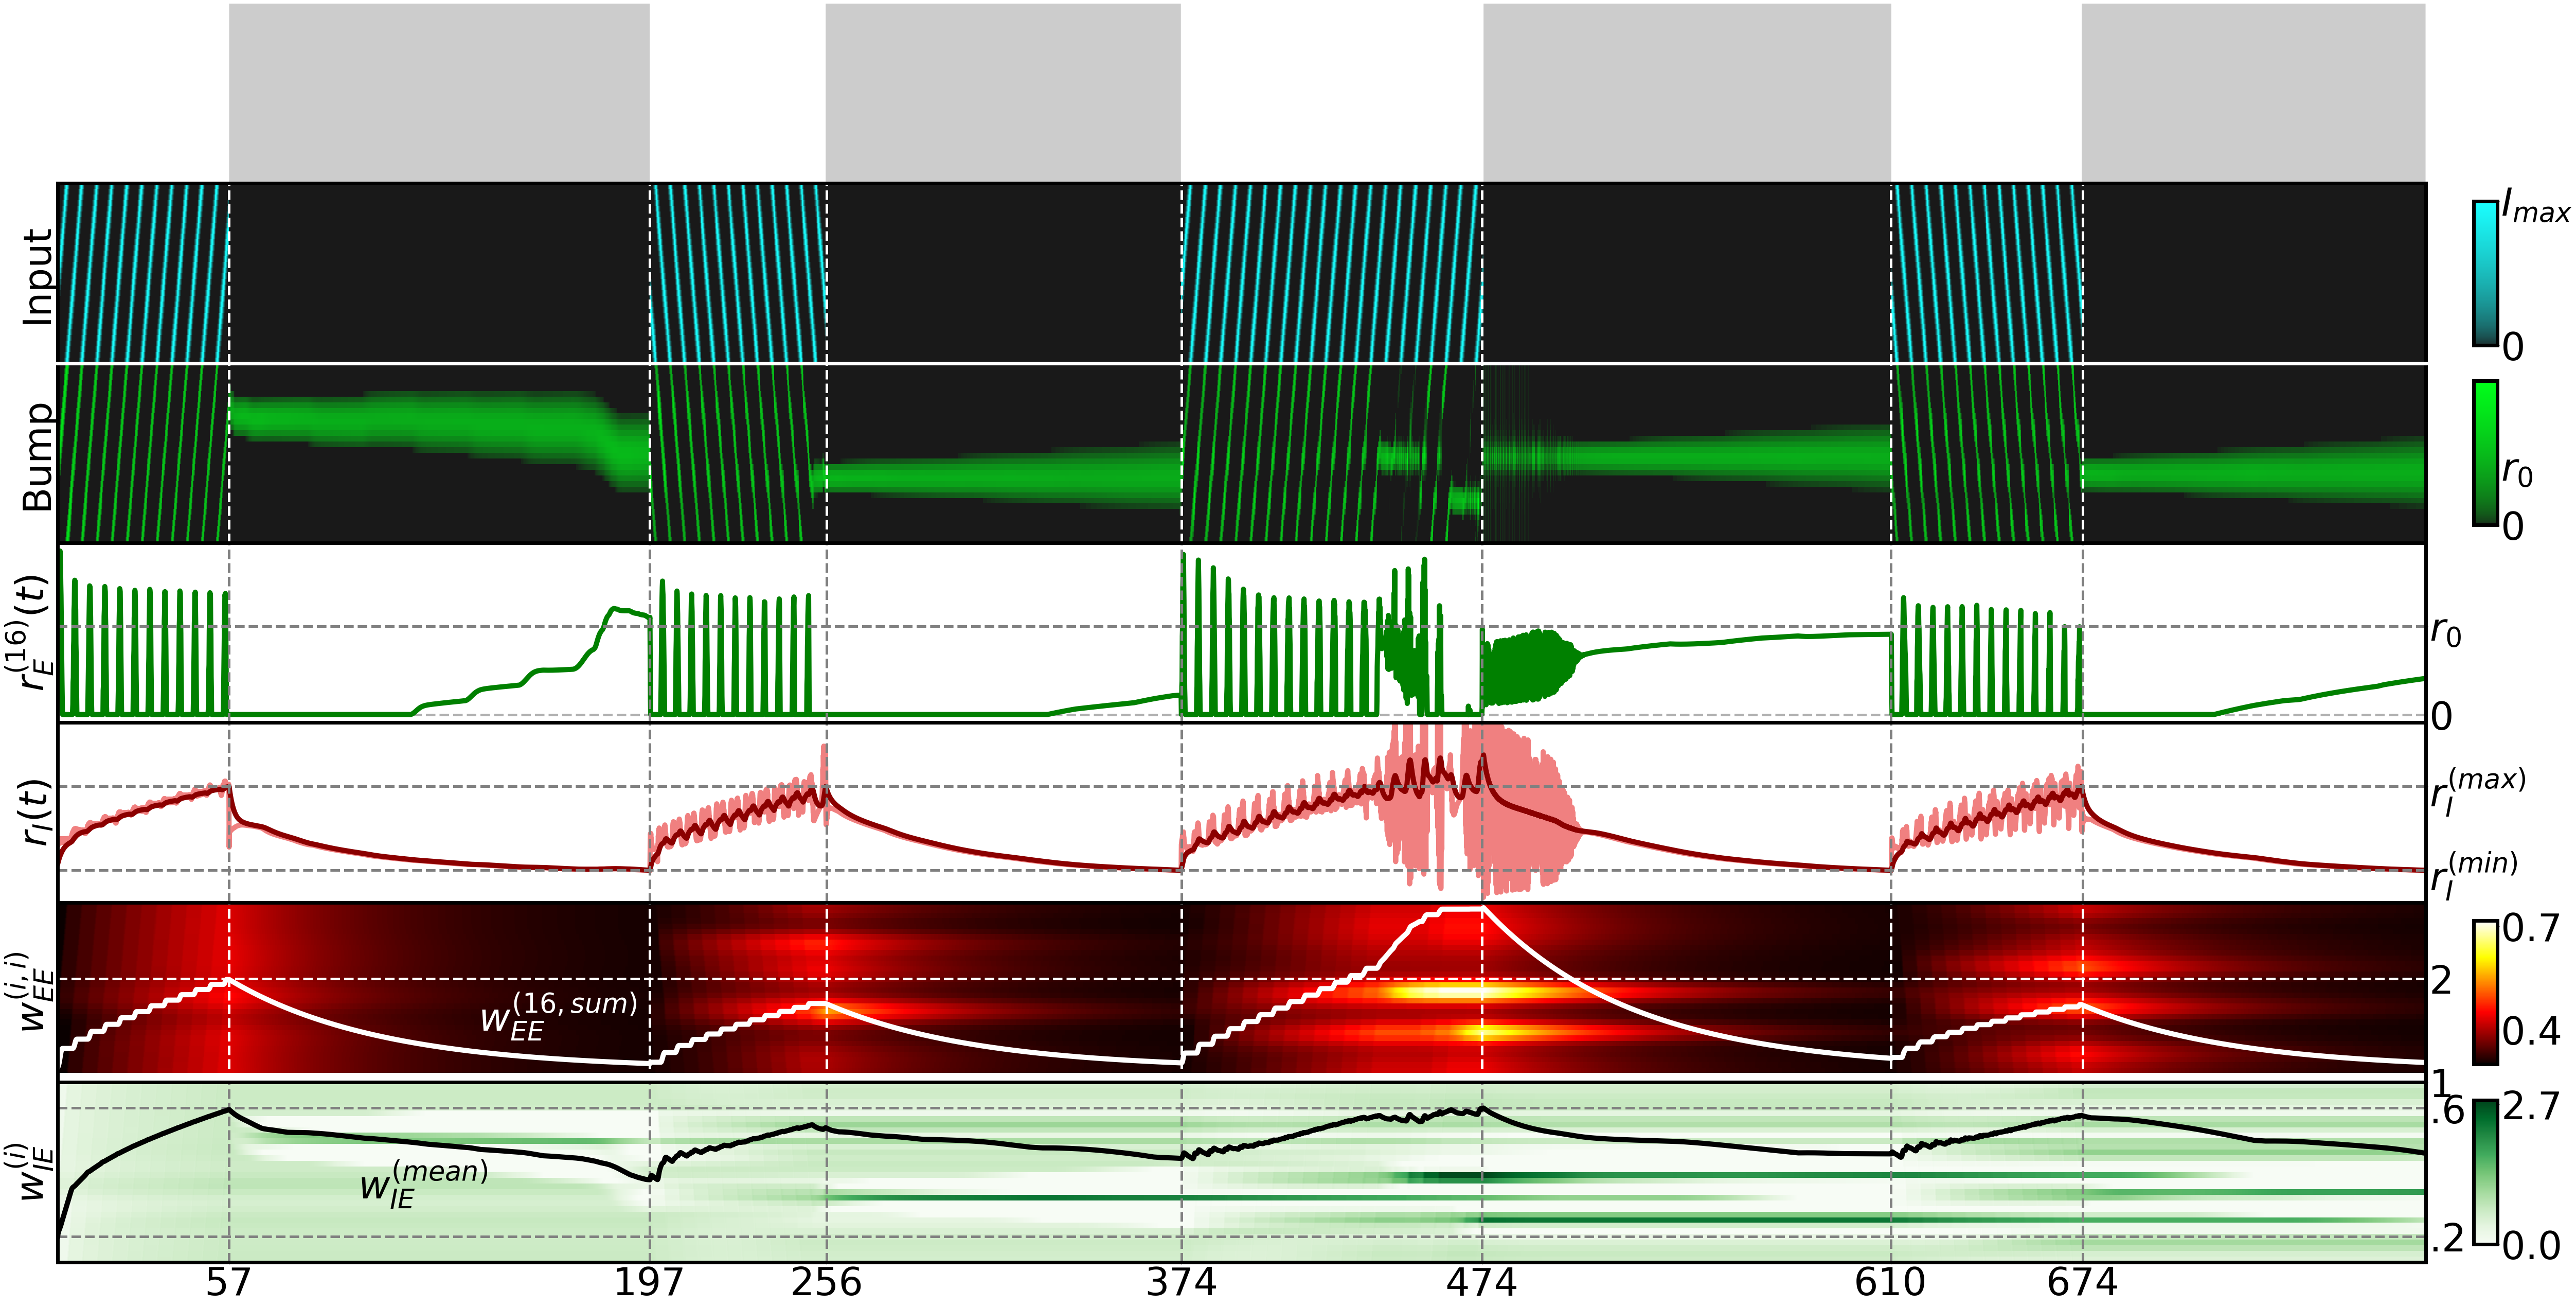

In [10]:
axes = plotSolutionAnalysis(X, params, min_time=0.1, max_time=788, 
                     time_step=time_step, sigma=1.5,
                    roll_bump = -4)


fsize = 75
axes[5].text(140, 1.5, r'$w_{EE}^{(16, sum)}$', color='white', fontsize= fsize)
axes[6].text(100, 0.3, r'$w_{IE}^{(mean)}$', color='black', fontsize= fsize)

plt.savefig(FIGURES_DIR + 'no_autonomous_activity_during_sleep/simulation.png')

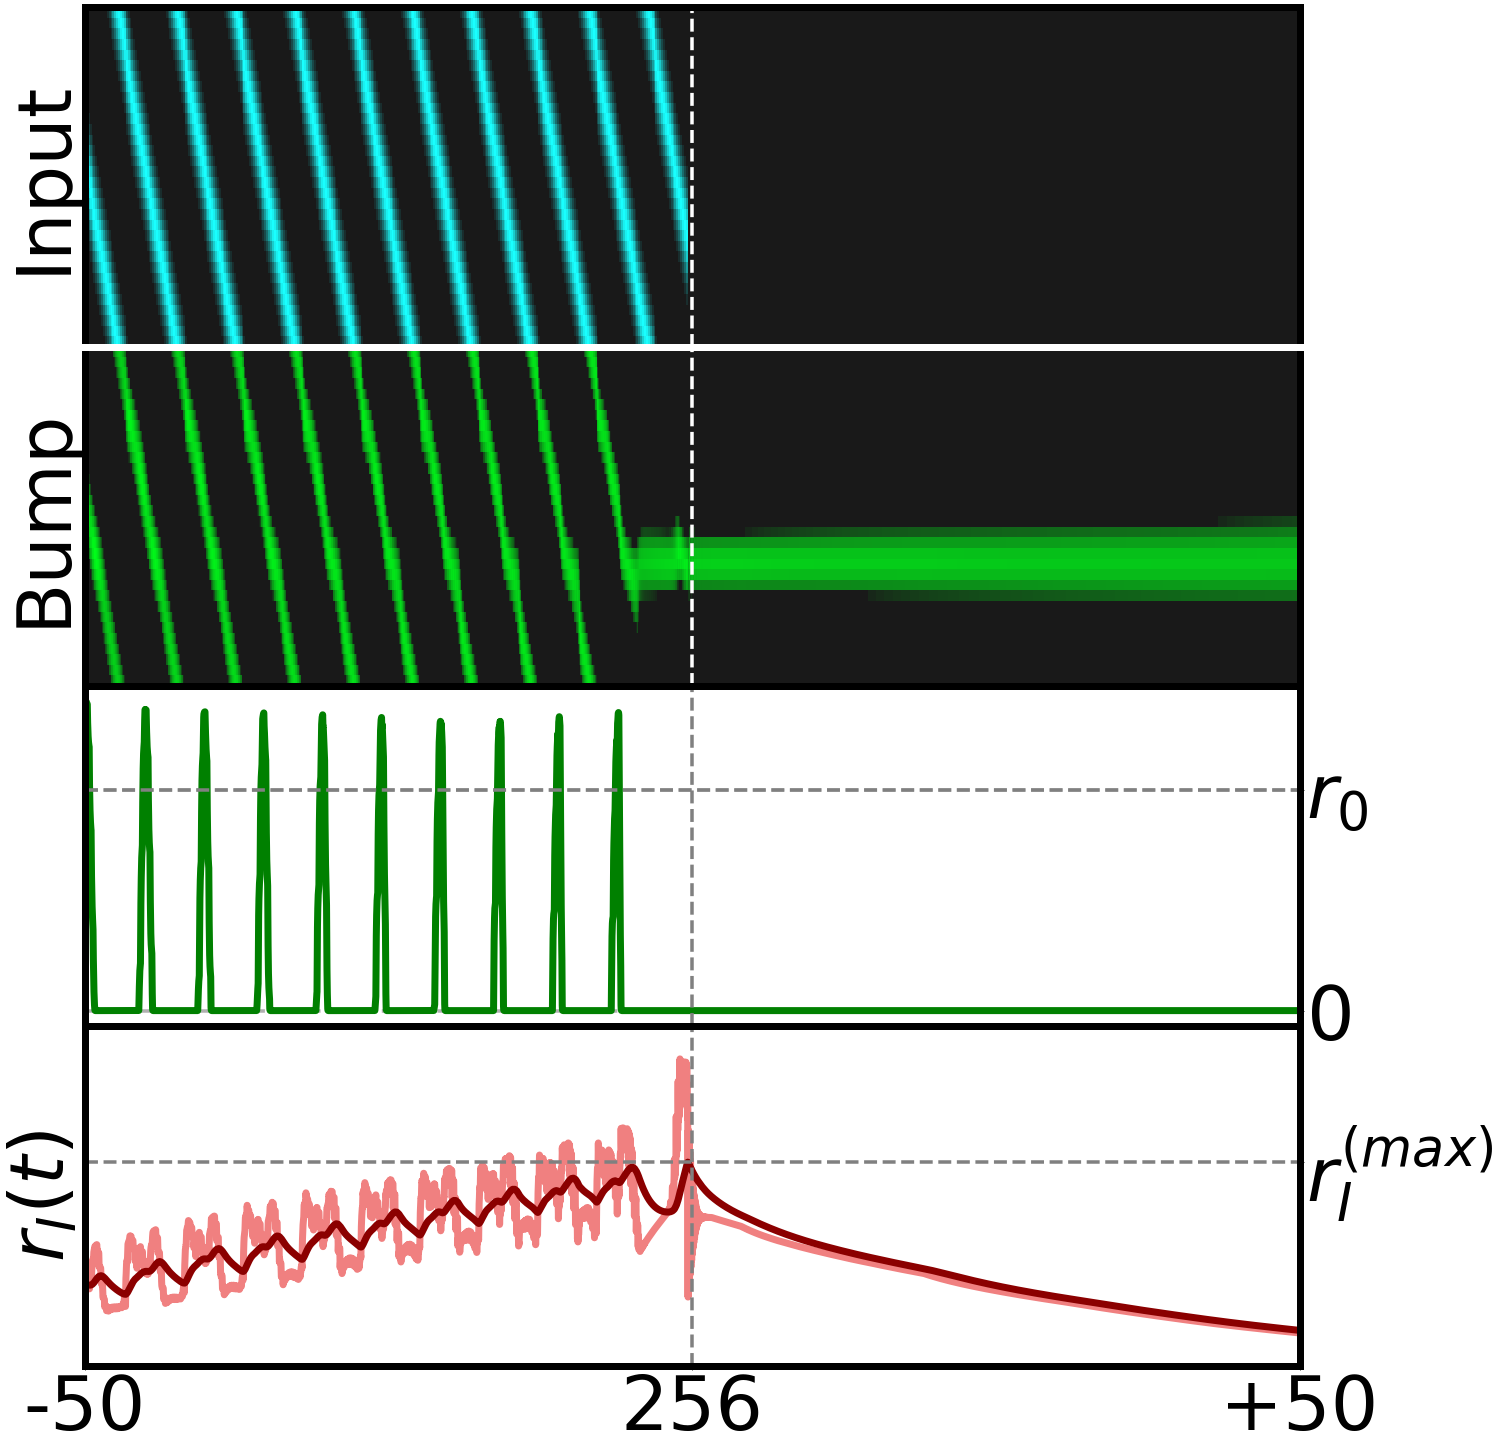

In [11]:
plotSolutionZoom(X, params, center_time=256, range_time=100, 
                     time_step=time_step, sigma=1.5, name = None,
                    roll_bump = -4)
plt.savefig(FIGURES_DIR + 'no_autonomous_activity_during_sleep/zoom_256.png')

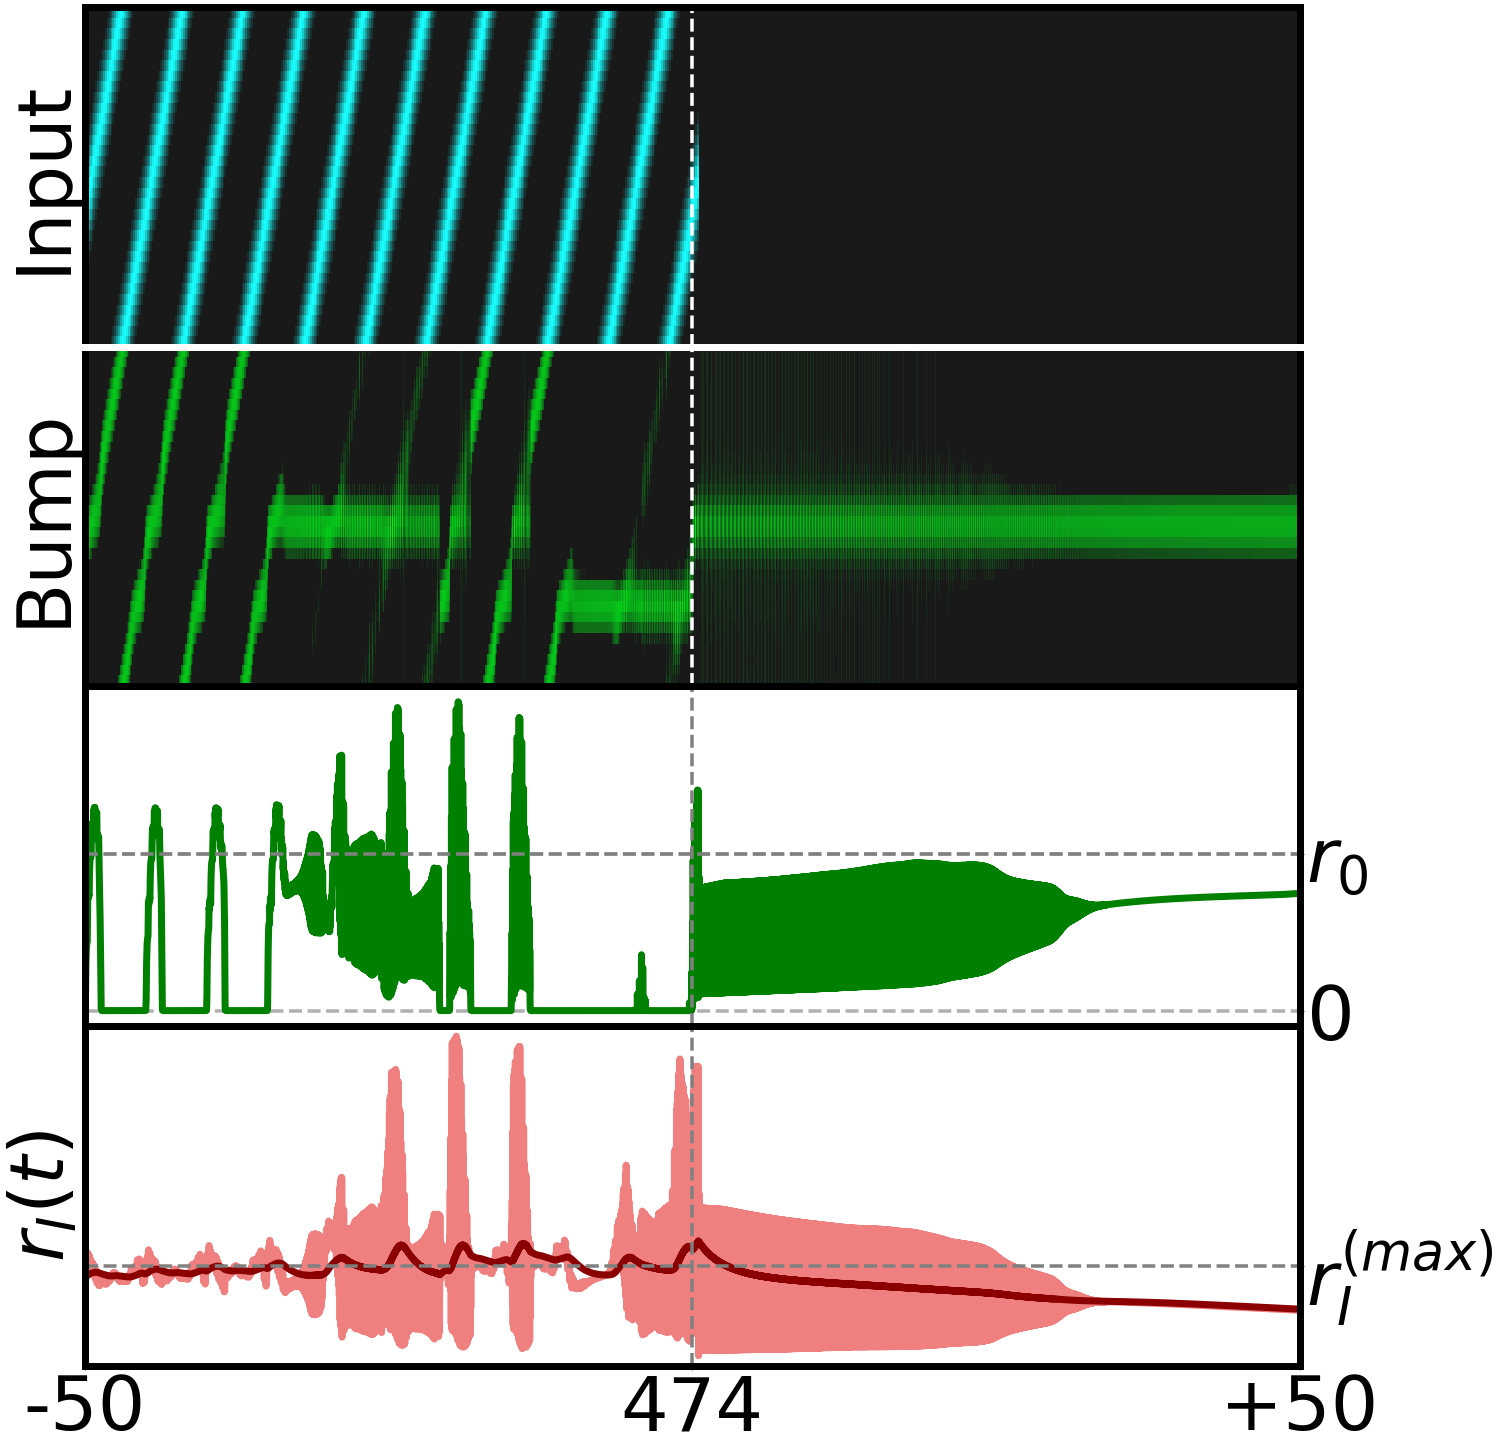

In [168]:
plotSolutionZoom(X, params, center_time=474, range_time=100, 
                     time_step=time_step, sigma=1.5, name = None,
                    roll_bump = -4)
plt.savefig(FIGURES_DIR + 'no_autonomous_activity_during_sleep/zoom_474.png')

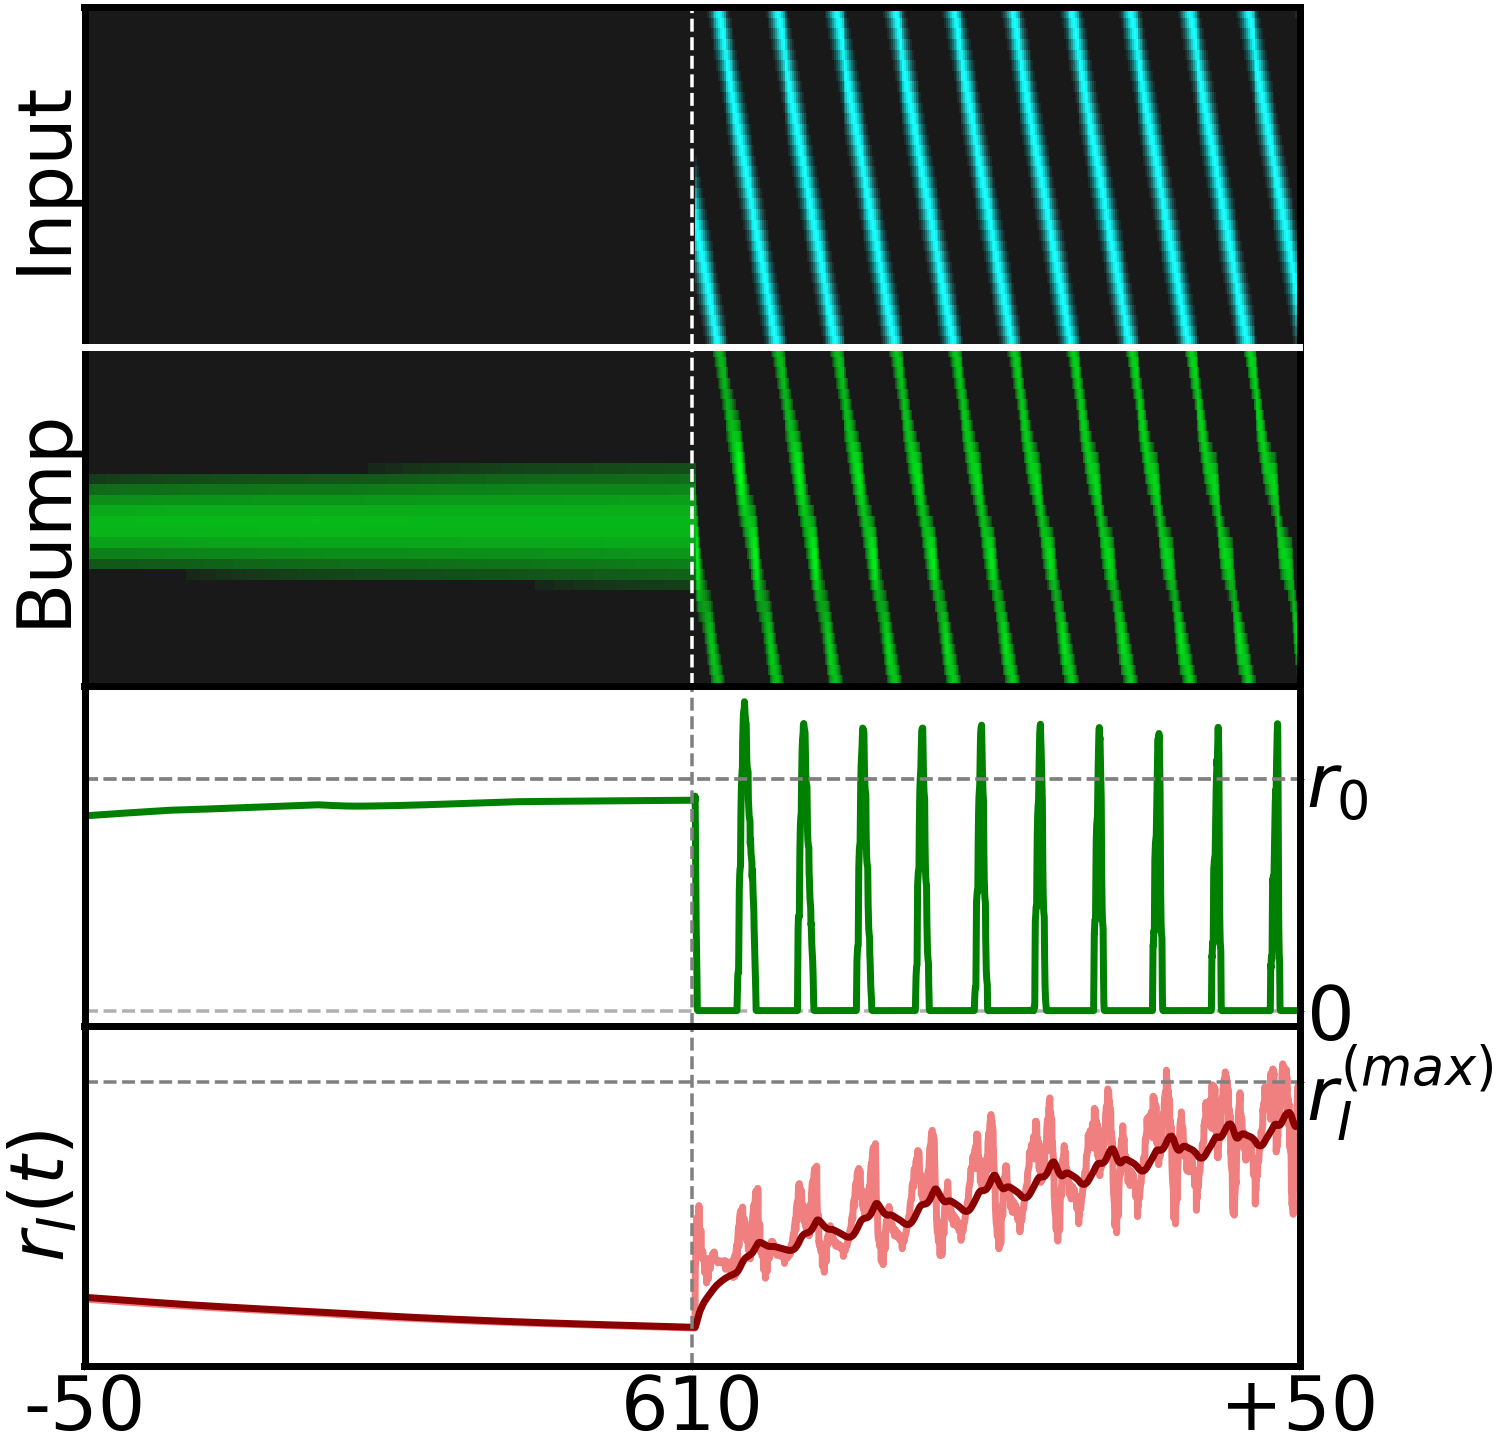

In [172]:
plotSolutionZoom(X, params, center_time=610, range_time=100, 
                     time_step=time_step, sigma=1.5, name = None,
                    roll_bump = -4)
plt.savefig(FIGURES_DIR + 'no_autonomous_activity_during_sleep/zoom_610.png')

## Zoom in during sleep deprivation

In [35]:
def plotSolutionAnalysis(X, params, min_time, max_time, time_step, sigma, points = 10000, roll_bump = 0):
    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.0, 0.0)],

             'green': [(0.0,  0.1, 0.1),
                       (1, 1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)]}
    gfp = LinearSegmentedColormap('gfp', cdict, N=256, gamma=0.5)

    cdict = {'red':   [(0.0,  0.1, 0.1),
                       (1.0,  0.1, 0.1)],

             'green':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)],

             'blue':  [(0.0,  0.1, 0.1),
                       (1.0,  1.0, 0.0)]}
    vis = LinearSegmentedColormap('vis', cdict, N=256, gamma=0.5)

    
    
    
    


    time, rE, rI, wEE, wIE, rI_filt = X
    tau, tauEE, tauIE, tau_filt, r0, wEI, rI_min, rI_max, Imax, Isigma, rot_freq, N, I, sleep, m, time_step   = params

    
    if max_time == -1:
        max_time = time[-1]
    
    min_ix = np.where(time > min_time)[0][0]
    max_ix = np.where(time < max_time)[0][-1]
    ix = np.linspace(min_ix, max_ix, points).astype(np.int)
    
    sleep   = sleep[ix]
    time    = time[ix]
    rE      = np.roll(rE[ix,:], roll_bump, axis = 1)
    rI      = rI[ix]
    rI_filt = rI_filt[ix]
    I       = np.roll(I[ix,:], roll_bump, axis = 1)

    wEE = wEE[ix]
    wEE = np.roll(wEE, roll_bump, axis = 1)
    wEE = np.roll(wEE, roll_bump, axis = 2)

    wIE = np.roll(wIE[ix,:], roll_bump, axis = 1)
    



    linewidth = 10
    
    
        
    fsize = 75
    plt.rcParams.update({'font.size': fsize})
    plt.rcParams['axes.linewidth'] = 7

    fig, axes = plt.subplots(5, 1, sharex=True, figsize=(85, 45))
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(top=0.6)


    
    
    ################## sleep and wake areas in the top ###############
    
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[0].fill_between(time, 0, 1,
                 where=sleep == 1 ,
                 facecolor='black', alpha=0.2)
    
    axes[0].set_ylim([0,1])
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    axes[0].axis('off')

    
    
    
    
    
    ############# INPUT ###############
    imI = axes[1].imshow(I.transpose(), aspect='auto', cmap = vis, origin='lower', 
                         extent = (min_time, max_time, 0, N-1 ) )
    
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barI = plt.colorbar(imI, cax=cax, ticks=[0, Imax])
    barI.ax.set_yticklabels(['0', '$I_{max}$'])

    axes[1].set_yticks([])
    axes[1].set_ylabel('Input')


    axes[1].spines["bottom"].set_color("white")

    
    ################ BUMP ################
    axes[2].spines["top"].set_color("white")
    imrE = axes[2].imshow(rE.transpose(), aspect='auto', cmap = gfp, origin='lower', 
                         extent = (min_time, max_time, 0, N-1) )
    
    axes[2].set_ylabel('Bump')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="1%", pad=1.3)
    cax.set_axis_off()
    cax = inset_axes(cax,
                       width="100%",  # width = 5% of parent_bbox width
                       height="80%",  # height : 50%
                       loc='right',
                       bbox_transform=cax.transAxes,
                       borderpad=0,
                       bbox_to_anchor=(0,0,1,1)
                       )
    
    barrE = plt.colorbar(imrE, cax=cax, ticks=[0, r0])
    barrE.ax.set_yticklabels(['0', '$r_0$'])
    axes[2].set_yticks([])


    ############ WEDGE NEURON 16 #############
    axes[3].plot(time, rE[:,16], color='green', linewidth = linewidth)
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[3].set_ylabel('$r_E^{(16)}(t)$')

    #axes[2].set_ylim([np.min(h[ix]) - 0.5*h_0, 2*h_0])

    plt.sca(axes[3])
    axes[3].yaxis.tick_right()
    plt.yticks([0, r0], ['0', '$r_0$'])
    axes[3].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')
    axes[3].axhline(r0, color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[3].set_xlim(min_time, max_time)

    
    
    ################# RING NEURONS ###############
    
    axes[4].plot(time, rI, color='lightcoral', linewidth = linewidth)
    axes[4].plot(time, rI_filt, color='darkred', linewidth = linewidth)
    divider = make_axes_locatable(axes[4])
    cax = divider.append_axes("right", size="1%", pad=1.3, visible = False)
    axes[4].set_ylabel('$r_I(t)$')
    plt.sca(axes[4])
    axes[4].yaxis.tick_right()
    plt.yticks([rI_min[0], rI_max[0]], [r'$r_I^{(min)}$', r'$r_I^{(max)}$'])
    axes[4].yaxis.grid(True, linewidth = linewidth/2, linestyle='dashed')

    axes[4].axhline(rI_min[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")
    axes[4].axhline(rI_max[0], color='grey', linewidth = linewidth/2, linestyle = "dashed")

    
    axes[4].set_xlim(min_time, max_time)
    axes[4].set_ylim([np.min(rI_filt) - 5, np.max(rI_filt) + 5])

    
    axes[4].set_xticks([min_time, max_time])
    axes[4].set_xlabel('Time (seconds)')


    
    axes_fillin = [0,3,4,6]

              
    return axes



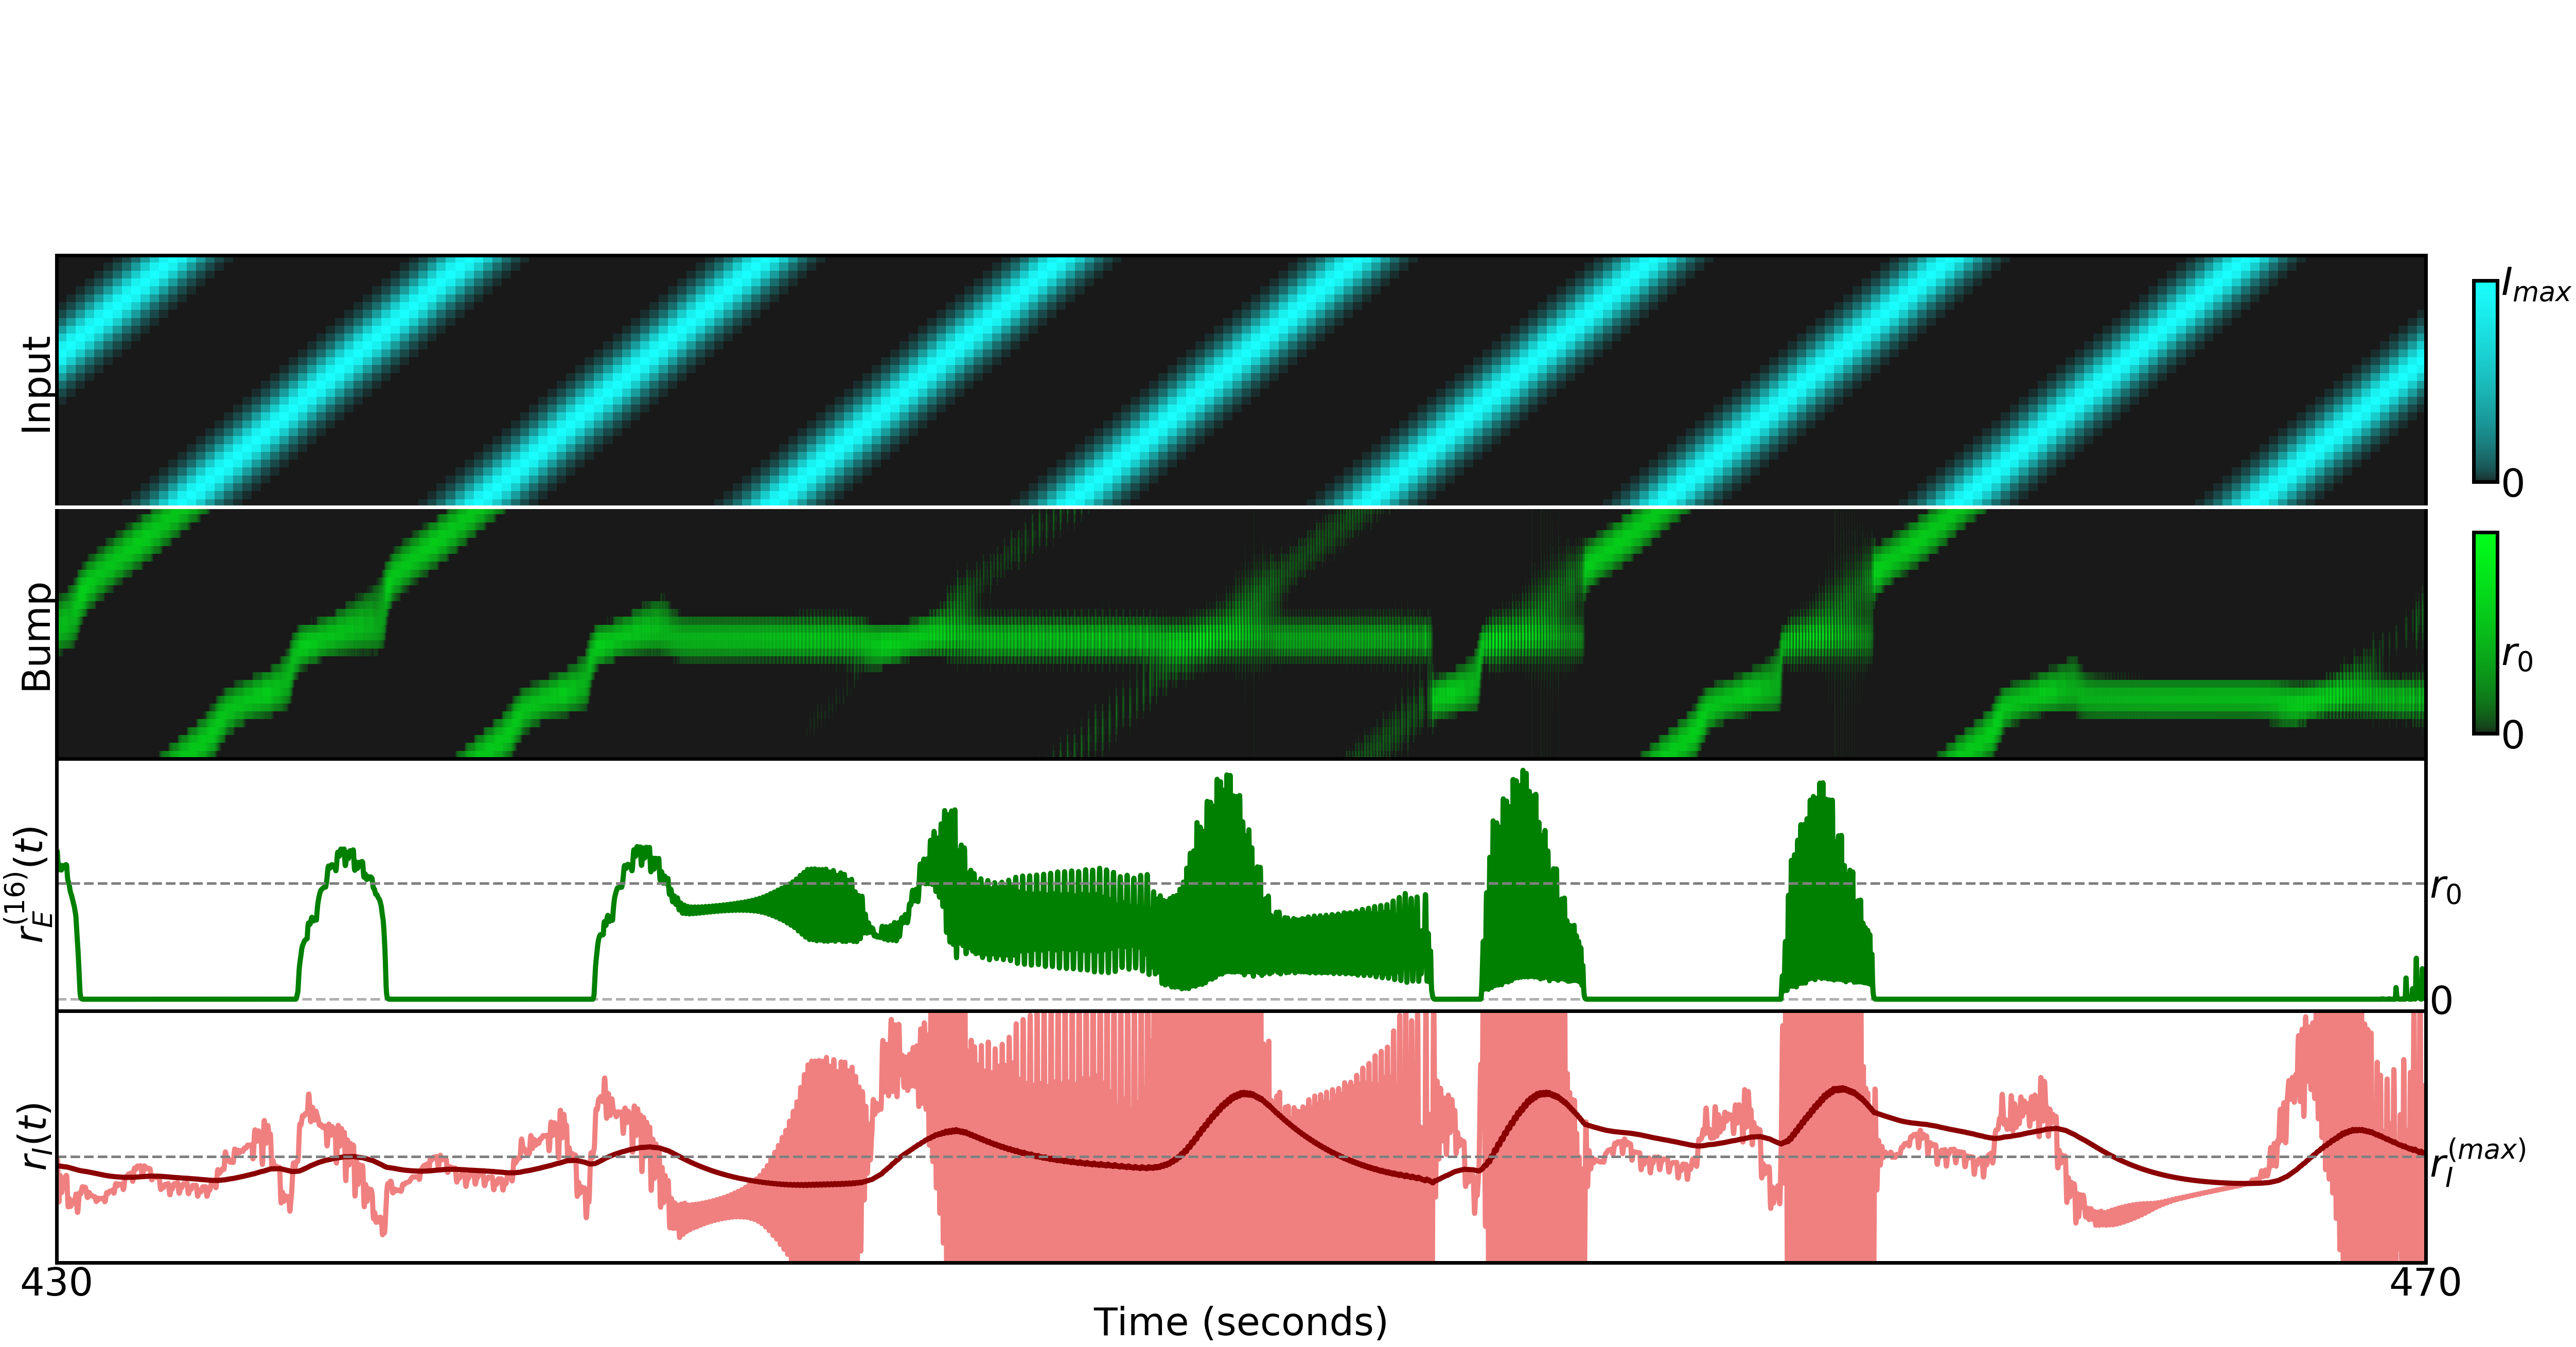

In [40]:
axes = plotSolutionAnalysis(X, params, min_time=430, max_time=470, 
                     time_step=time_step, sigma=1.5,
                    roll_bump = -4)
plt.savefig(FIGURES_DIR + '/zoom_rebutal.png', dpi = 40)